In [1]:
import os
import scipy.io as sio
import sys 
import h5py as hp
import argparse
import random
from random import choices, choice
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import colors
from IPython.display import HTML, display, Image
from numpy.fft import ifft2,fft2,fft,ifft,fftfreq, fftshift
from scipy.signal import convolve2d, correlate2d
from IPython.display import HTML, display, Image
import time
from tqdm.auto import tqdm
from scipy.io import loadmat
from scipy.interpolate import interp1d

import torch
import math
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils import data
from tifffile import imread
from torchsummary import summary
from torch.nn.utils import spectral_norm
import itertools


def rebin(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

def rebin1d(arr, new_shape):
    shape = (new_shape, arr.shape[0] // new_shape)
    return arr.reshape(shape).mean(-1)

def normalize(x):
    return (x-np.amin(x))/(np.amax(x)-np.amin(x))

def centralpadding(arr, new_shape):
    if new_shape[0]>=arr.shape[0]:
        newarr = np.zeros(new_shape,dtype=complex)
        newarr[(new_shape[0] - arr.shape[0]) //2 : (new_shape[0] + arr.shape[0]) //2 ,
               (new_shape[1] - arr.shape[1]) //2 : (new_shape[1] + arr.shape[1]) //2 ] = arr
    else:
        newarr= arr[(-new_shape[0] + arr.shape[0]) //2 : (new_shape[0] + arr.shape[0]) //2 ,
               (-new_shape[1] + arr.shape[1]) //2 : (new_shape[1] + arr.shape[1]) //2 ]
    return newarr

def radial_profile(data, center):
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)
    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile

def moving_average_smooth(data,window_width):
    cumsum_vec = np.cumsum(np.insert(data, 0, 0)) 
    ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
    return ma_vec
def autocor2d(I):
    f = fft2(I)
    f = np.absolute(f)**2
    autocor2d = ifftshift(ifft2(f))/I.shape[0]/I.shape[1]
    return autocor2d

def axis1norm(X):
    Y=np.zeros((X.shape[0],X.shape[1]))
    for i in range(X.shape[0]):
        Y[i,:] = X[i,:]/np.mean(X[i,:]**1)
    return Y

def axis0norm(X):
    Y=np.zeros((X.shape[0],X.shape[1]))
    for i in range(X.shape[1]):
        Y[:,i] = X[:,i]/np.mean(X[:,i]) 
    return Y

def ReLU(x):
    return x * (x > 0)


name = [#one interval
        '0-106 μm',
        '106-180 μm',
        '180-250 μm',
        '250-300 μm',
        '300-355 μm',
        '355-425 μm',
        '425-500 μm',
        '500-1000 μm',
        #two interval
        '106-250 μm',
        '180-300 μm',
        '250-355 μm',
        '300-425 μm',
        '355-500 μm',
        #three interval
        '180-355 μm',
        '250-425 μm',
        '300-500 μm',
        '355-1000 μm',
        #four interval
        '180-425 μm',
        '250-500 μm',
        #five interval
        '180-500 μm']



In [2]:
data_exp = np.load('expdata/20curves_PSD_cumul_auto_sa.npz')
PSD_exp = data_exp["PSD_exp"] # PSD of the measured data
cumul_exp = data_exp['cumul_exp'] #cumul of the measured data
auto_exp = np.abs(data_exp['auto_sa'].reshape((20,20,1,64,64)))**0.25 #measured 200 frames average-autocorrelation
#take the 0.25 power to enhance the feature

data_sim = np.load('expdata/simulation_PSD_cumul_auto.npz')
PSD_sim = data_sim["PSD_sim"] # PSD of the synthetic data
cumul_sim = data_sim['cumul_sim'] #cumul of the synthetic data
auto_sim = np.abs(data_sim['auto_sim'].reshape((2000,1,64,64)))**0.25 #calculation from the synthetic data 
auto_expgen = np.abs(data_sim['auto_expgen'].reshape((20,20,1,64,64)))**0.25 #calculation from the measured PSD

print(auto_exp.shape)
print(auto_sim.shape)
print(auto_expgen.shape)

(20, 20, 1, 64, 64)
(2000, 1, 64, 64)
(20, 20, 1, 64, 64)


In [3]:
#even index sets go to the training set (only train G)
#odd index sets go to the test set

auto_exp_train = np.zeros((10,20,1,64,64))
auto_expgen_train = np.zeros((10,20,1,64,64))
cumul_exp_train = np.zeros((10,20,192))

auto_exp_test = np.zeros((10,20,1,64,64))
auto_expgen_test = np.zeros((10,20,1,64,64))
cumul_exp_test = np.zeros((10,20,192))

for i in range(10):
    auto_exp_train[i] = auto_exp[2*i]
    auto_exp_test[i] = auto_exp[2*i+1]
    
    auto_expgen_train[i] = auto_expgen[2*i]
    auto_expgen_test[i] = auto_expgen[2*i+1]
    
    cumul_exp_train[i] = cumul_exp[2*i]
    cumul_exp_test[i] = cumul_exp[2*i+1]

In [5]:
split_point= 1600
batch_size = 4

############ set sim data ############

###train data
traindata_sim_a = torch.tensor(auto_sim[0:split_point], dtype=torch.float)
traindata_sim_c = torch.tensor(cumul_sim[0:split_point], dtype=torch.float)
#build dataset
trainset_sim = data.TensorDataset(traindata_sim_a,traindata_sim_c)
#load data
train_sim = torch.utils.data.DataLoader(trainset_sim, batch_size = batch_size, shuffle = True)


###test data
valdata_sim_a = torch.tensor(auto_sim[split_point:2000], dtype=torch.float)
valdata_sim_c = torch.tensor(cumul_sim[split_point:2000], dtype=torch.float)
#build dataset
valset_sim = data.TensorDataset(valdata_sim_a, valdata_sim_c)
#load data
val_sim = torch.utils.data.DataLoader(valset_sim, batch_size = batch_size, shuffle = True)

############ set exp data ############

###train data
traindata_exp_a = torch.tensor(np.concatenate(auto_exp_train,axis=0), dtype=torch.float)
traindata_exp_agen = torch.tensor(np.concatenate(auto_expgen_train,axis=0), dtype=torch.float)
traindata_exp_c = torch.tensor(np.concatenate(cumul_exp_train,axis=0), dtype=torch.float)
#build dataset
trainset_exp = data.TensorDataset(traindata_exp_agen,traindata_exp_a,traindata_exp_c)#, traindata_exp_c)
#load data
train_exp = torch.utils.data.DataLoader(trainset_exp, batch_size = batch_size, shuffle = True)



###test data
valdata_exp_agen = torch.tensor(np.concatenate(auto_expgen_test,axis=0), dtype=torch.float)
valdata_exp_a = torch.tensor(np.concatenate(auto_exp_test,axis=0), dtype=torch.float)
valdata_exp_c = torch.tensor(np.concatenate(cumul_exp_test,axis=0), dtype=torch.float)
#build dataset
valset_exp = data.TensorDataset(valdata_exp_agen, valdata_exp_a,valdata_exp_c)
#load data
val_exp = torch.utils.data.DataLoader(valset_exp, batch_size = batch_size, shuffle = True)


In [51]:

class residual_block(nn.Module):
    def __init__(self, in_filters,out_filters, kernel_size=(3,3), stride_1=1,stride_2=1,dilation=(2,2),activation='leaky_relu'):
        super(residual_block, self).__init__()
        self.out_filters = out_filters
        self.in_filters = in_filters
        self.kernel_size = kernel_size
        self.stride_1 = stride_1 #the first block stride, 1 for normal, 2 for downsampling
        self.stride_2 = stride_2 #the second block stride, 1 for normal, 2 for downsampling
        self.dilation = dilation
        self.pad_1 = (2+dilation[0]*(kernel_size[0]-1)-stride_1)//2
        self.pad_2 = (2+dilation[0]*(kernel_size[0]-1)-stride_2)//2
        if activation=='leaky_relu':
            self.a = nn.LeakyReLU()#F.leaky_relu()
        elif activation=='relu':
            self.a = nn.ReLU()#F.relu()
        elif activation=='sigmoid':
            self.a = nn.Sigmoid()
        elif activation=='tanh':
            self.a = nn.Tanh()
            
        self.bn1 = nn.InstanceNorm2d(self.in_filters)
        self.bn2 = nn.InstanceNorm2d(self.out_filters)
        self.conv1 = nn.Conv2d(self.in_filters,self.out_filters, self.kernel_size, 
                               stride=self.stride_1, dilation=self.dilation,padding=self.pad_1)
        
        self.conv2 = nn.Conv2d(self.out_filters,self.out_filters, self.kernel_size, 
                               stride=self.stride_2, dilation=self.dilation,padding=self.pad_2)
        
        self.conv3 = nn.Conv2d(self.in_filters,self.out_filters, kernel_size=(1,1), padding=0,
                               stride=self.stride_1,dilation=(1,1))

    def forward(self, x):
        res = self.bn1(x)
        res = self.a(res)
        shortcut = self.conv3(res)
        res = self.conv1(res)
        res = self.bn2(res)
        res = self.a(res)
        res = self.conv2(res)
        res = res+shortcut
        
        return res
    
class down_residual_layer(nn.Module):
    def __init__(self, in_filters,out_filters, kernel_size=(3,3), stride_1=2,stride_2=1,dilation=(2,2),activation='leaky_relu'):
        super(down_residual_layer, self).__init__()
        self.out_filters = out_filters
        self.in_filters = in_filters
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.stride_1 = stride_1
        self.stride_2 = stride_2
        self.activation = activation
        self.residual_block_1 = residual_block(self.in_filters,self.out_filters, kernel_size=self.kernel_size, 
                                               stride_1=self.stride_1,stride_2=self.stride_2,dilation=(1,1),activation=self.activation)

        self.residual_block_2 = residual_block(self.out_filters,self.out_filters, kernel_size=self.kernel_size, 
                                               stride_1=1,stride_2=1,dilation=self.dilation, activation=self.activation)
        
        self.dropout = nn.Dropout(0.05)
        
    def forward(self, x):
        x = self.residual_block_1(x)
        x = self.residual_block_2(x)
        output = self.dropout(x)
        return output

    
class Generator(nn.Module):
    def __init__(self, fd):
        super(Generator, self).__init__()
        self.filters = fd
        self.pad_1 = (2+1*(3-1)-1)//2
        self.pad_2 = (2+1*(1-1)-1)//2
        
        self.residual_block_1 = residual_block(self.filters[0]+1,self.filters[1], kernel_size=(3,3), dilation=(1,1),stride_1=1,stride_2=1,activation='relu')

        self.residual_block_2 = residual_block(self.filters[1],self.filters[2], kernel_size=(3,3), dilation=(1,1),stride_1=1,stride_2=1,activation='relu')

        self.conv1 = nn.Conv2d(2*self.filters[0],self.filters[0], kernel_size=(3,3), 
                               stride=1, dilation=(1,1),padding=self.pad_1)
        self.conv2 = nn.Conv2d(self.filters[0],self.filters[0], kernel_size=(1,1), 
                               stride=1, dilation=(1,1),padding=self.pad_2)
        self.dropout = nn.Dropout(0.05)
   

    def forward(self, x):
        n = torch.randn(x.shape).cuda()
        n = torch.cat( (x,n),dim=1)
                                           
        d1 = self.residual_block_1(n)
        d2 = self.residual_block_2(d1)

        x = self.conv2(x)
        x = F.relu(x)

        m = torch.cat( (x,d2),dim=1)
        m = self.conv1(m)

        output = torch.sigmoid(1* m) 
        return output

            
                   
class Predictor(nn.Module):
    def __init__(self, fd):
        super(Predictor, self).__init__()
        self.filters = fd
        self.down_residual_layer_1 = down_residual_layer(self.filters[0],self.filters[1], kernel_size=(3,3), dilation=(1,1),stride_1=2,stride_2=1)    
        self.down_residual_layer_2 = down_residual_layer(self.filters[1],self.filters[2], kernel_size=(3,3), dilation=(1,1),stride_1=2,stride_2=1)  
        self.down_residual_layer_3 = down_residual_layer(self.filters[2],self.filters[3], kernel_size=(3,3), dilation=(1,1),stride_1=2,stride_2=1) 
        self.down_residual_layer_4 = down_residual_layer(self.filters[3],self.filters[4], kernel_size=(3,3), dilation=(1,1))    

        self.bn = nn.InstanceNorm2d(self.filters[3])
        self.dropout = nn.Dropout(0.05)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(4*4*self.filters[4], 192)   

    def forward(self, x):
        x = self.down_residual_layer_1(x)
        x = self.down_residual_layer_2(x)
        x = self.down_residual_layer_3(x)
        x = self.down_residual_layer_4(x)
        x = self.bn(x)
        x = F.leaky_relu(x,negative_slope=0.1)
        x = self.flatten(x)
        x = self.linear1(x)
        output = torch.sigmoid(x)
        return output

    def first_stage_output(self,x):
        output = self.down_residual_layer_1(x)
        return output
    
    def second_stage_output(self,x):
        x = self.down_residual_layer_1(x)
        output = self.down_residual_layer_2(x)
        return output
    
    def third_stage_output(self,x):
        x = self.down_residual_layer_1(x)
        x = self.down_residual_layer_2(x)
        output = self.down_residual_layer_3(x)
        return output
    
    def fourth_stage_output(self,x):
        x = self.down_residual_layer_1(x)
        x = self.down_residual_layer_2(x)
        x = self.down_residual_layer_3(x)
        output = self.down_residual_layer_4(x)
        return output

In [52]:

generator = Generator(fd = [1, 24, 1])
generator.cuda()


predictor = Predictor(fd = [1,8,16,32,64])
predictor.cuda()

summary(predictor, (1, 64, 64))
summary(generator, (1, 64, 64))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
    InstanceNorm2d-1            [-1, 1, 64, 64]               0
         LeakyReLU-2            [-1, 1, 64, 64]               0
            Conv2d-3            [-1, 8, 32, 32]              16
            Conv2d-4            [-1, 8, 32, 32]              80
    InstanceNorm2d-5            [-1, 8, 32, 32]               0
         LeakyReLU-6            [-1, 8, 32, 32]               0
            Conv2d-7            [-1, 8, 32, 32]             584
    residual_block-8            [-1, 8, 32, 32]               0
    InstanceNorm2d-9            [-1, 8, 32, 32]               0
        LeakyReLU-10            [-1, 8, 32, 32]               0
           Conv2d-11            [-1, 8, 32, 32]              72
           Conv2d-12            [-1, 8, 32, 32]             584
   InstanceNorm2d-13            [-1, 8, 32, 32]               0
        LeakyReLU-14            [-1, 8,

In [53]:

def g_loss_npcc2d(generated_image, true_image):
    fsp=generated_image-torch.mean(generated_image,dim=(0,1,2,3),keepdim=True)
    fst=true_image-torch.mean(true_image,dim=(0,1,2,3),keepdim=True)
    
    devP=torch.std(generated_image,dim=(0,1,2,3))
    devT=torch.std(true_image,dim=(0,1,2,3))
    
    npcc_loss=(-1)*torch.mean(fsp*fst,dim=(0,1,2,3))/torch.clamp(devP*devT,1e-10,None)    ## (BL,1)
    return npcc_loss


#G training hyperparameters
num_epochs_G = 60
learning_rate_g = 0.002 # learning rate for generator G
loss_fn_G = g_loss_npcc2d  #loss for generator G
g_optimizer = torch.optim.Adam(generator.parameters(), lr = learning_rate_g)
g_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(g_optimizer, factor=0.5, patience=1000,threshold=0.002,
                                                       threshold_mode='abs', min_lr=1e-7, eps=1e-08, verbose=True)

#F training hyperparameters
num_epochs_F = 60
learning_rate_p = 0.0002 # learning rate for estimator F
loss_fn_F =  nn.L1Loss() #loss for estimator F
p_optimizer = torch.optim.Adam(predictor.parameters(), lr = learning_rate_p)
p_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(p_optimizer, factor=0.5, patience=6,threshold=0.0002,
                                                       threshold_mode='abs', min_lr=1e-7, eps=1e-08, verbose=True)


In [54]:
#Estimator training

#validation with exp data
Val_Loss_G = []

pbar = tqdm(range(num_epochs_G))

for epoch in pbar:
    
    ######## training process ########
    exp_iter = iter(train_exp)
    
    times = len(train_exp)
    start_time = time.time()
    for i in range(times):

        exp_agen, exp_a,exp_c = exp_iter.next()

        exp_a = exp_a.cuda()
        exp_agen = exp_agen.cuda()
        exp_c = exp_c.cuda()

        ############################
        # (1) Update G network
        ##########################
        generator.zero_grad()
        
        generated_c  = generator(exp_agen) #the calculated auto from experimental PSD
        errCond =loss_fn_G(generated_c, exp_a) 

        errG =    errCond 
        errG.backward()
        g_optimizer.step()
        ############################
        # (2) check the training loss
        ###########################
        if i % 20 == 0:
            print('[%d/%d][%d/%d]\t G_Loss: %.4f \t%.4f s'
                  % (epoch, num_epochs_G, i, times,
                    errG.item(), time.time()-start_time))
            start_time = time.time()


    ############### validation set ################
    exp_iter = iter(val_exp)
    valloss_G = 0
    times = len(val_exp)
    with torch.no_grad():
        for i in range(times):
    
            exp_agen, exp_a, _ = exp_iter.next()
            exp_agen = exp_agen.cuda()
            exp_a = exp_a.cuda()
            
            generated_a = generator(exp_agen)
            err_valG = loss_fn_G(generated_a,exp_a)
            valloss_G += err_valG.mean().item()
            
    Val_Loss_G.append(valloss_G/times)
    g_scheduler.step(Val_Loss_G[-1])


    print("Val: Epoch: %d | generator_loss: %f" %(epoch + 1, Val_Loss_G[-1] ))



[0/60][0/50]	 G_Loss: 0.3414 	0.0051 s
[0/60][20/50]	 G_Loss: -0.7830 	0.0870 s
[0/60][40/50]	 G_Loss: -0.9035 	0.0865 s
Val: Epoch: 1 | generator_loss: -0.936051
[1/60][0/50]	 G_Loss: -0.9260 	0.0047 s
[1/60][20/50]	 G_Loss: -0.9602 	0.0828 s
[1/60][40/50]	 G_Loss: -0.9447 	0.0822 s
Val: Epoch: 2 | generator_loss: -0.967066
[2/60][0/50]	 G_Loss: -0.9595 	0.0045 s
[2/60][20/50]	 G_Loss: -0.9811 	0.0920 s
[2/60][40/50]	 G_Loss: -0.9707 	0.0937 s
Val: Epoch: 3 | generator_loss: -0.975074
[3/60][0/50]	 G_Loss: -0.9864 	0.0051 s
[3/60][20/50]	 G_Loss: -0.9894 	0.0981 s
[3/60][40/50]	 G_Loss: -0.9722 	0.0971 s
Val: Epoch: 4 | generator_loss: -0.980939
[4/60][0/50]	 G_Loss: -0.9898 	0.0050 s
[4/60][20/50]	 G_Loss: -0.9648 	0.0979 s
[4/60][40/50]	 G_Loss: -0.9902 	0.0965 s
Val: Epoch: 5 | generator_loss: -0.982663
[5/60][0/50]	 G_Loss: -0.9834 	0.0051 s
[5/60][20/50]	 G_Loss: -0.9931 	0.0969 s
[5/60][40/50]	 G_Loss: -0.9894 	0.0935 s
Val: Epoch: 6 | generator_loss: -0.980887
[6/60][0/50]	 G_L

Val: Epoch: 50 | generator_loss: -0.995321
[50/60][0/50]	 G_Loss: -0.9960 	0.0048 s
[50/60][20/50]	 G_Loss: -0.9962 	0.0846 s
[50/60][40/50]	 G_Loss: -0.9967 	0.0844 s
Val: Epoch: 51 | generator_loss: -0.995694
[51/60][0/50]	 G_Loss: -0.9973 	0.0046 s
[51/60][20/50]	 G_Loss: -0.9961 	0.0843 s
[51/60][40/50]	 G_Loss: -0.9966 	0.0844 s
Val: Epoch: 52 | generator_loss: -0.995435
[52/60][0/50]	 G_Loss: -0.9968 	0.0046 s
[52/60][20/50]	 G_Loss: -0.9966 	0.0843 s
[52/60][40/50]	 G_Loss: -0.9956 	0.0843 s
Val: Epoch: 53 | generator_loss: -0.995918
[53/60][0/50]	 G_Loss: -0.9960 	0.0046 s
[53/60][20/50]	 G_Loss: -0.9974 	0.0843 s
[53/60][40/50]	 G_Loss: -0.9963 	0.0843 s
Val: Epoch: 54 | generator_loss: -0.994912
[54/60][0/50]	 G_Loss: -0.9959 	0.0046 s
[54/60][20/50]	 G_Loss: -0.9965 	0.0841 s
[54/60][40/50]	 G_Loss: -0.9973 	0.0843 s
Val: Epoch: 55 | generator_loss: -0.995819
[55/60][0/50]	 G_Loss: -0.9971 	0.0046 s
[55/60][20/50]	 G_Loss: -0.9974 	0.0842 s
[55/60][40/50]	 G_Loss: -0.9961 	0

In [55]:

#training loss
Loss_cycle = []

#validation with exp data
Val_Loss_F = []

#validation with sim data
Val_Loss_Cycle = []

pbar = tqdm(range(num_epochs_F))

for epoch in pbar:
    
    ######## training process ########
    sim_iter = iter(train_sim)
    exp_iter = iter(train_exp)

    times = min(len(train_sim), len(train_exp))
    start_time = time.time()
    for i in range(times):
        
        sim_a, sim_c = sim_iter.next()
        sim_a = sim_a.cuda()
        sim_c = sim_c.cuda()

        ############################
        # (1) Update F network: minimize L1(f - F(G(gi)) )
        ###########################
        predictor.zero_grad()

        output_c = predictor( generator(sim_a) ) 
        errCycle = loss_fn_F(output_c, sim_c) 
        errF = errCycle
        Loss_cycle.append(errCycle.item())
                
        errF.backward()
        p_optimizer.step()

        ############################
        # (2) check the training loss
        ###########################
        if i % 20 == 0:
            print('[%d/%d][%d/%d]\t Training_Loss: %.4f \t%.4f s'
                  % (epoch, num_epochs_F, i, times,
                    errCycle.item(), time.time()-start_time))
            start_time = time.time()


    ############### test set exp ################
    exp_iter = iter(val_exp)
    valloss_F = 0
    times = len(val_exp)
    with torch.no_grad():
        for i in range(times):
    
            exp_agen, exp_a,exp_c = exp_iter.next()
            exp_agen = exp_agen.cuda()
            exp_a = exp_a.cuda()
            exp_c = exp_c.cuda()

            predicted_c = predictor(exp_a)#, lambda_)
            err_valF = loss_fn_F(predicted_c,exp_c)
            valloss_F += err_valF.mean().item()
            
    Val_Loss_F.append(valloss_F/times)

    ############### test set sim ################
    sim_iter = iter(val_sim)
    valloss_Cycle = 0
    times = len(val_sim)
    with torch.no_grad():

        for i in range(times):
    
            sim_a,sim_c = sim_iter.next()
            sim_a = sim_a.cuda()
            sim_c = sim_c.cuda()

            predicted_c = predictor(generator(sim_a))#, lambda_)
            err_valCycle = loss_fn_F(predicted_c,sim_c)
            valloss_Cycle += err_valCycle.mean().item()
        Val_Loss_Cycle.append(valloss_Cycle/times)
    p_scheduler.step(Val_Loss_F[-1])

    print("Val: Epoch: %d | exp_estimator_Loss: %f| sim_estimator_Loss: %f" %(epoch + 1, 
                                                                      Val_Loss_F[-1],
                                                                      Val_Loss_Cycle[-1]))


[0/60][0/50]	 Training_Loss: 0.4461 	0.0131 s
[0/60][20/50]	 Training_Loss: 0.2822 	0.2289 s
[0/60][40/50]	 Training_Loss: 0.1557 	0.2246 s
Val: Epoch: 1 | exp_estimator_Loss: 0.130760| sim_estimator_Loss: 0.164314
[1/60][0/50]	 Training_Loss: 0.1723 	0.0117 s
[1/60][20/50]	 Training_Loss: 0.1682 	0.2284 s
[1/60][40/50]	 Training_Loss: 0.1662 	0.2244 s
Val: Epoch: 2 | exp_estimator_Loss: 0.083788| sim_estimator_Loss: 0.112259
[2/60][0/50]	 Training_Loss: 0.1457 	0.0116 s
[2/60][20/50]	 Training_Loss: 0.0883 	0.2280 s
[2/60][40/50]	 Training_Loss: 0.0697 	0.2233 s
Val: Epoch: 3 | exp_estimator_Loss: 0.110475| sim_estimator_Loss: 0.086260
[3/60][0/50]	 Training_Loss: 0.0785 	0.0116 s
[3/60][20/50]	 Training_Loss: 0.0480 	0.2283 s
[3/60][40/50]	 Training_Loss: 0.0572 	0.2231 s
Val: Epoch: 4 | exp_estimator_Loss: 0.049658| sim_estimator_Loss: 0.047921
[4/60][0/50]	 Training_Loss: 0.0304 	0.0116 s
[4/60][20/50]	 Training_Loss: 0.0392 	0.2334 s
[4/60][40/50]	 Training_Loss: 0.0361 	0.2293 s


[37/60][20/50]	 Training_Loss: 0.0189 	0.2251 s
[37/60][40/50]	 Training_Loss: 0.0151 	0.2231 s
Val: Epoch: 38 | exp_estimator_Loss: 0.030758| sim_estimator_Loss: 0.018833
[38/60][0/50]	 Training_Loss: 0.0151 	0.0117 s
[38/60][20/50]	 Training_Loss: 0.0185 	0.2252 s
[38/60][40/50]	 Training_Loss: 0.0162 	0.2229 s
Val: Epoch: 39 | exp_estimator_Loss: 0.030359| sim_estimator_Loss: 0.017790
[39/60][0/50]	 Training_Loss: 0.0167 	0.0115 s
[39/60][20/50]	 Training_Loss: 0.0309 	0.2266 s
[39/60][40/50]	 Training_Loss: 0.0115 	0.2277 s
Val: Epoch: 40 | exp_estimator_Loss: 0.029885| sim_estimator_Loss: 0.018063
[40/60][0/50]	 Training_Loss: 0.0157 	0.0117 s
[40/60][20/50]	 Training_Loss: 0.0271 	0.2260 s
[40/60][40/50]	 Training_Loss: 0.0120 	0.2282 s
Epoch    41: reducing learning rate of group 0 to 6.2500e-06.
Val: Epoch: 41 | exp_estimator_Loss: 0.029901| sim_estimator_Loss: 0.018514
[41/60][0/50]	 Training_Loss: 0.0165 	0.0116 s
[41/60][20/50]	 Training_Loss: 0.0188 	0.2312 s
[41/60][40/50]

<ipython-input-56-e751bb252c2b>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_tick_params(labelsize=14,width=1.5)
<ipython-input-56-e751bb252c2b>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().yaxis.set_tick_params(labelsize=14,width=1.5)
<ipython-input-56-e751bb252c2b>:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier 

[None, None, None, None]

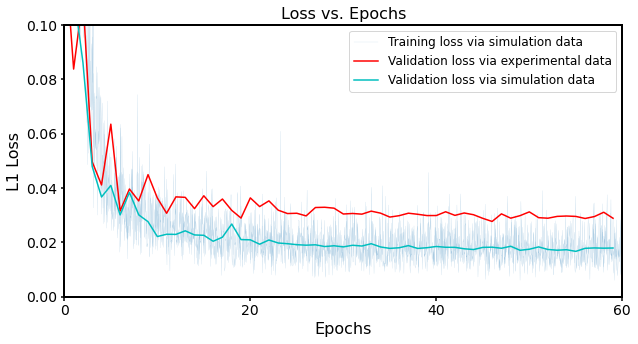

In [56]:

plt.figure(figsize=(10,5))
plt.title("Loss vs. Epochs",fontsize=16)
plt.plot((np.arange(len(Loss_cycle))+1)/50,Loss_cycle, alpha=0.7,
         linewidth=0.1, label='Training loss via simulation data')
plt.plot(Val_Loss_F, 'r-',label='Validation loss via experimental data')
plt.plot(Val_Loss_Cycle,'c-', label='Validation loss via simulation data')
plt.ylim(0,0.1)
plt.legend()
plt.xlim(0,60)
plt.xticks([0,20,40,60])
plt.legend(prop={'size': 12})
plt.axes().xaxis.set_tick_params(labelsize=14,width=1.5)
plt.axes().yaxis.set_tick_params(labelsize=14,width=1.5)
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('L1 Loss',fontsize=16)
[x.set_linewidth(2) for x in plt.axes().spines.values()]
